In [1]:
!pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to c:\users\ciell\appdata\local\temp\pip-req-build-t1lpperc
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git 'C:\Users\ciell\AppData\Local\Temp\pip-req-build-t1lpperc'


In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

from tqdm.notebook import tqdm

In [3]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [4]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

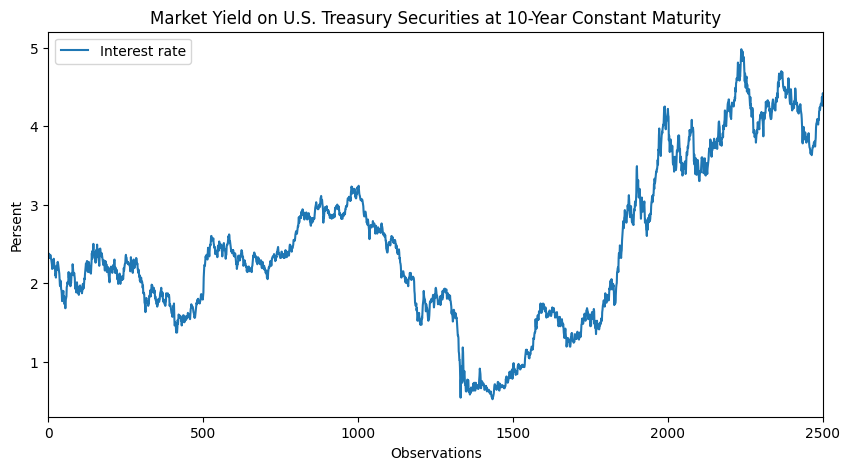

In [5]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

In [6]:
try:
  df_IR['DGS10'] = df_IR['DGS10'].astype('Float64')
  df_IR.index = pd.to_datetime(df_IR['DATE'])
  df_IR.drop(columns=['DATE'], inplace=True)
except:
  pass

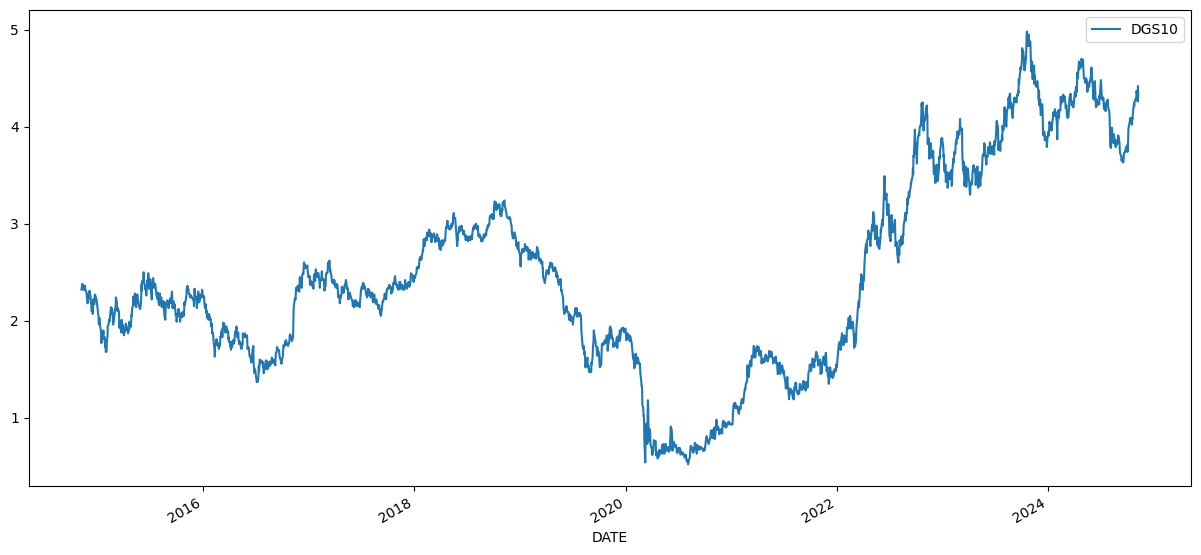

In [7]:
df_IR.plot(figsize=(15,7))
plt.show()

In [8]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [9]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -12669.493522214383
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 87, CG iterations: 51, optimality: 5.44e-04, constraint violation: 0.00e+00, execution time: 0.054 s.
Final Params: [0.20085071 0.85443313]
Final Likelihood: 3759.2355769705873
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.58366375833


c:\python\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 430, CG iterations: 271, optimality: 1.67e+00, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.03194853 0.2210937  0.72599512 0.19166242]
Final Likelihood: 3784.2117711976457
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2333.161650315157
`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 124, CG iterations: 36, optimality: 1.87e+00, constraint violation: 0.00e+00, execution time: 0.029 s.
Final Params: [0.01657517 0.07411057 0.58646291]
Final Likelihood: 3705.89724897373
Initial Params: [0.01, 0.2]
Initial Likelihood: 689.6896241768532
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 159, CG iterations: 70, optimality: 7.82e-01, constraint violation: 0.00e+00, execution time: 0.083 s.
Final Params: [0.09377205 0.44436301]
Final Likelihood: 3258.597061957374
Initial Params: [0.01, 0

In [10]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -7514.471 - BrownianMotion model with params [0.20085071 0.85443313],
       -7560.424 - CEV model with params [0.03194853 0.2210937  0.72599512 0.19166242],
       -7405.794 - CIR model with params [0.01657517 0.07411057 0.58646291],
       -6513.194 - GeometricBM model with params [0.09377205 0.44436301],
       -6514.924 - IGBM model with params [0.36666297 2.4572849  0.44399559],
       -7512.944 - OrnsteinUhlenbeck model with params [0.18182955 3.5520446  0.85435193],
       -7561.301 - CKLS model with params [0.13849965 0.03808474 0.72465482 0.19487216],
       
The best model is CKLS     with param [0.13849965 0.03808474 0.72465482 0.19487216]


In [11]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -12669.493522200273
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 99, CG iterations: 53, optimality: 3.79e-05, constraint violation: 0.00e+00, execution time: 0.051 s.
Final Params: [0.20051325 0.85443317]
Final Likelihood: 3759.235577751262
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.70075386972
`xtol` termination condition is satisfied.
Number of iterations: 197, function evaluations: 1005, CG iterations: 677, optimality: 9.54e-03, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.16806972 3.83801774 0.72779206 0.18936574]
Final Likelihood: 3785.06883892766
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2336.230683007224
`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 304, CG iterations: 160, optimality: 1.35e-02, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.27933314 3

In [12]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -7514.471 - BrownianMotion model with params [0.20051325 0.85443317],
       -7562.138 - CEV model with params [0.16806972 3.83801774 0.72779206 0.18936574],
       -7408.716 - CIR model with params [0.27933314 3.20912262 0.58672537],
       -6514.788 - GeometricBM model with params [0.09722226 0.44514257],
       -6514.186 - IGBM model with params [0.19479396 2.86053058 0.44527763],
       -7512.943 - OrnsteinUhlenbeck model with params [0.18490598 3.55374223 0.85466593],
       -7561.520 - CKLS model with params [0.21835746 0.01005528 0.72780838 0.18904834],
       
The best model is CEV     with param [0.16806972 3.83801774 0.72779206 0.18936574]


In [13]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -12669.493522200271
`xtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 120, CG iterations: 56, optimality: 9.01e-06, constraint violation: 0.00e+00, execution time: 0.049 s.
Final Params: [0.20051376 0.85443317]
Final Likelihood: 3759.2355777512494
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.57052975317
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 305, CG iterations: 208, optimality: 8.70e-06, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.19857573 3.48154386 0.72753647 0.18938328]
Final Likelihood: 3785.079349974285
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2335.9098493678566
`gtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 180, CG iterations: 96, optimality: 3.17e-07, constraint violation: 0.00e+00, execution time: 0.081 s.
Final Params: [0.28461355

In [14]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -7514.471 - BrownianMotion model with params [0.20051376 0.85443317],
       -7562.159 - CEV model with params [0.19857573 3.48154386 0.72753647 0.18938328],
       -7408.717 - CIR model with params [0.28461355 3.15344436 0.58639566],
       -6514.788 - GeometricBM model with params [0.09519507 0.44522843],
       -6514.187 - IGBM model with params [0.18677273 2.94541611 0.44510382],
       -7512.944 - OrnsteinUhlenbeck model with params [0.18152056 3.55356999 0.85435246],
       -7561.520 - CKLS model with params [0.2185864  0.01000209 0.72782289 0.18904854],
       
The best model is CEV     with param [0.19857573 3.48154386 0.72753647 0.18938328]


In [15]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.03194853 0.2210937  0.72599512 0.19166242],
     [0.16806972 3.83801774 0.72779206 0.18936574],
     [0.19857573 3.48154386 0.72753647 0.18938328]


In [16]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [17]:
# Словарь с моделями, методами, их параметрами и пределами
model_details = {
    "Kessler": {"density": KesslerDensity, "params": {}},
    "Shoji-Ozaki": {"density": ShojiOzakiDensity, "params": {}},
    "Euler": {"density": EulerDensity, "params": {}}
}

# Обновляем модели и параметры
models = {
    "BrownianMotion": {"class": BrownianMotion(), "bounds": [(0.01, 10), (0.01, 2)], "guess": [0.01, 0.2]},
    "CEV": {"class": CEV(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.01, 0.2]},
    "CIR": {"class": CIR(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.2]},
    "GeometricBM": {"class": GeometricBM(), "bounds": [(0.01, 10), (0.01, 2)], "guess": [0.01, 0.2]},
    "IGBM": {"class": IGBM(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.2]},
    "OrnsteinUhlenbeck": {"class": OrnsteinUhlenbeck(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.2]},
    "CKLS": {"class": CKLS(), "bounds": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], "guess": [0.01, 0.01, 0.01, 0.2]}
}

dt = 1. / 252

# Цикл для оценки параметров с использованием разных методов
for method, details in model_details.items():
    density_func = details["density"]
    params_estimates = []
    
    for model_name, model_info in models.items():
        bounds = model_info["bounds"]
        initial_guess = model_info["guess"]
        model_instance = model_info["class"]
        
        # Оценка параметров с использованием выбранного метода
        estimator = AnalyticalMLE(sample, bounds, dt, density=density_func(model_instance))
        estimated_params = estimator.estimate_params(initial_guess)
        aic_value = estimated_params.aic
        details["params"][model_name] = {
            "params": estimated_params.params,
            "aic": aic_value
        }
        
        print(f"AIC for {method} estimation ({model_name}): {aic_value} with params {estimated_params.params}")
        
    # Поиск модели с наименьшим AIC для текущего метода
    best_model = min(details["params"].items(), key=lambda item: item[1]["aic"])
    print(f"Best model for {method} method: {best_model[0]} with AIC {best_model[1]['aic']} and params {best_model[1]['params']}\n")

Initial Params: [0.01, 0.2]
Initial Likelihood: -12669.493522214383
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 87, CG iterations: 51, optimality: 5.44e-04, constraint violation: 0.00e+00, execution time: 0.05 s.
Final Params: [0.20085071 0.85443313]
Final Likelihood: 3759.2355769705873
AIC for Kessler estimation (BrownianMotion): -7514.471153941175 with params [0.20085071 0.85443313]
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.58366375833
`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 430, CG iterations: 271, optimality: 1.67e+00, constraint violation: 0.00e+00, execution time:  0.3 s.
Final Params: [0.03194853 0.2210937  0.72599512 0.19166242]
Final Likelihood: 3784.2117711976457
AIC for Kessler estimation (CEV): -7560.423542395291 with params [0.03194853 0.2210937  0.72599512 0.19166242]
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2333.161650315157
`xtol` ter

In [18]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [19]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

C:\Users\ciell\AppData\Local\Temp\ipykernel_464\1721718896.py:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


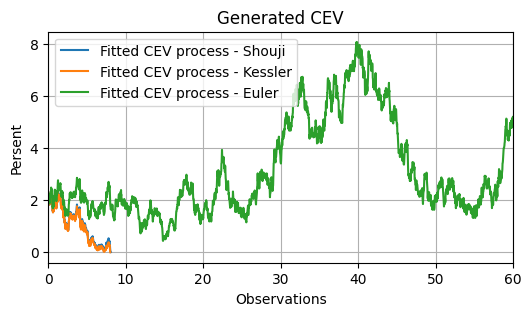

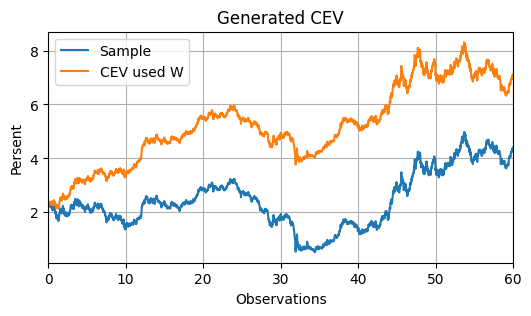

In [20]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

C:\Users\ciell\AppData\Local\Temp\ipykernel_464\1075863584.py:3: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


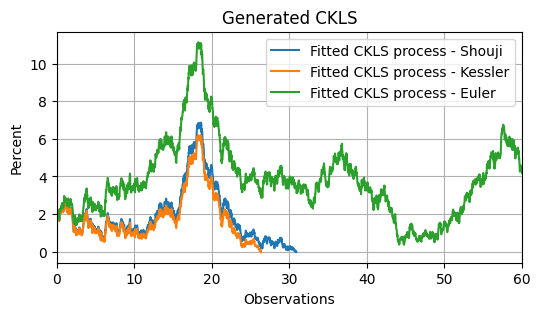

In [21]:
# Определяем процесс CKLS
def CKLS_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

# Параметры, оцененные для CKLS модели
# Можно использовать параметры, которые вы оценили ранее
kappa, mu, sigma, gamma = kessler_p  # Подставьте сюда параметры

# Генерация временной линии и Винеровского процесса
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)

# Инициализация массивов для хранения значений процесса CKLS
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0

# Генерация процесса CKLS для каждой из оцененных параметров
for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + CKLS_pr(ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + CKLS_pr(ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + CKLS_pr(ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)

# Визуализация процесса CKLS
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label="Fitted CKLS process - Shouji")
plt.plot(time_line, ckls_k, label="Fitted CKLS process - Kessler")
plt.plot(time_line, ckls_e, label="Fitted CKLS process - Euler")
plt.title("Generated CKLS")
plt.ylabel('Percent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [22]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -12669.493522200271
`xtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 120, CG iterations: 56, optimality: 9.01e-06, constraint violation: 0.00e+00, execution time: 0.049 s.
Final Params: [0.20051376 0.85443317]
Final Likelihood: 3759.2355777512494
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.57052975317
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 305, CG iterations: 208, optimality: 8.70e-06, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.19857573 3.48154386 0.72753647 0.18938328]
Final Likelihood: 3785.079349974285
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2335.9098493678566
`gtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 180, CG iterations: 96, optimality: 3.17e-07, constraint violation: 0.00e+00, execution time: 0.075 s.
Final Params: [0.28461355

c:\python\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.70045260474
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 420, CG iterations: 261, optimality: 6.87e-04, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.21439273 3.42462853 0.72674753 0.19030726]
Final Likelihood: 3785.151409719155
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2336.2287977227525
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 332, CG iterations: 171, optimality: 2.02e-03, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.38675331 2.96780913 0.58597695]
Final Likelihood: 3708.141992868779
Initial Params: [0.01, 0.2]


Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [23]:
!pip install ace_tools

In [24]:

# Число наблюдений в выборке
n = len(sample)

# Инициализация пустого DataFrame для хранения всех результатов
results_df = pd.DataFrame(columns=["Method", "Model", "Params", "AIC", "BIC"])

# Функция для расчета BIC через AIC, если log_likelihood недоступен
def calculate_bic_from_aic(aic_value, n, num_params):
    log_likelihood = -0.5 * aic_value
    return num_params * np.log(n) - 2 * log_likelihood

# Итерация по каждому методу и каждой модели
for method, details in model_details.items():
    density_func = details["density"]
    
    for model_name, model_info in models.items():
        bounds = model_info["bounds"]
        initial_guess = model_info["guess"]
        model_instance = model_info["class"]
        
        # Оценка параметров и получение AIC для текущей модели и метода
        estimator = AnalyticalMLE(sample, bounds, dt, density=density_func(model_instance))
        estimated_params = estimator.estimate_params(initial_guess)
        
        # Извлекаем AIC и рассчитываем BIC на его основе
        aic_value = estimated_params.aic
        num_params = len(estimated_params.params)
        bic_value = calculate_bic_from_aic(aic_value, n, num_params)
        
        # Создание строки результата в виде DataFrame
        result_row = pd.DataFrame({
            "Method": [method],
            "Model": [model_name],
            "Params": [estimated_params.params],
            "AIC": [aic_value],
            "BIC": [bic_value]
        })
        
        # Объединение текущего результата с основным DataFrame
        results_df = pd.concat([results_df, result_row], ignore_index=True)

# Отображение таблицы результатов
# import ace_tools as tools; tools.display_dataframe_to_user(name="Comprehensive Model Comparison", dataframe=results_df)
results_df

Initial Params: [0.01, 0.2]
Initial Likelihood: -12669.493522214383
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 87, CG iterations: 51, optimality: 5.44e-04, constraint violation: 0.00e+00, execution time: 0.048 s.
Final Params: [0.20085071 0.85443313]
Final Likelihood: 3759.2355769705873
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -156192.58366375833


C:\Users\ciell\AppData\Local\Temp\ipykernel_464\4291424407.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)
c:\python\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 430, CG iterations: 271, optimality: 1.67e+00, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.03194853 0.2210937  0.72599512 0.19166242]
Final Likelihood: 3784.2117711976457
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2333.161650315157
`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 124, CG iterations: 36, optimality: 1.87e+00, constraint violation: 0.00e+00, execution time: 0.042 s.
Final Params: [0.01657517 0.07411057 0.58646291]
Final Likelihood: 3705.89724897373
Initial Params: [0.01, 0.2]
Initial Likelihood: 689.6896241768532
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 159, CG iterations: 70, optimality: 7.82e-01, constraint violation: 0.00e+00, execution time: 0.071 s.
Final Params: [0.09377205 0.44436301]
Final Likelihood: 3258.597061957374
Initial Params: [0.01, 0

,Method,Model,Params,AIC,BIC
0,Kessler,BrownianMotion,"[0.20085070957160084, 0.8544331256082225]",-7514.471154,-7498.821463
1,Kessler,CEV,"[0.031948530487130596, 0.221093698089135, 0.72...",-7560.423542,-7529.124160
2,Kessler,CIR,"[0.016575165273691555, 0.07411057041827776, 0....",-7405.794498,-7382.319961
3,Kessler,GeometricBM,"[0.09377204812578475, 0.44436301179343723]",-6513.194124,-6497.544433
4,Kessler,IGBM,"[0.3666629724438087, 2.4572849042149074, 0.443...",-6514.924061,-6491.449524
5,Kessler,OrnsteinUhlenbeck,"[0.18182955134319828, 3.5520446005354462, 0.85...",-7512.943531,-7489.468994
6,Kessler,CKLS,"[0.13849965224390332, 0.03808473933988364, 0.7...",-7561.301073,-7530.001690
7,Shoji-Ozaki,BrownianMotion,"[0.20051324943930804, 0.8544331735387183]",-7514.471156,-7498.821464
8,Shoji-Ozaki,CEV,"[0.1680697163576946, 3.838017744662613, 0.7277...",-7562.137678,-7530.838295
9,Shoji-Ozaki,CIR,"[0.2793331423298182, 3.2091226208122205, 0.586...",-7408.715643,-7385.241106


In [25]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [26]:
# Run estimator with parallel calculating:
# K = 100
# i_range   = [i for i in tqdm(range(100))]
# pool_obj = multiprocessing.Pool()
# answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

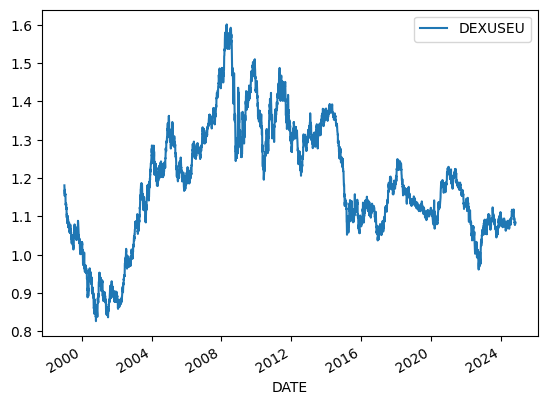

In [27]:
dexuseu = pd.read_csv('DEXUSEU.csv')
dexuseu.index = pd.to_datetime(dexuseu['DATE'])
dexuseu.drop(columns=['DATE'])
dexuseu = dexuseu[dexuseu['DEXUSEU'] != '.']
dexuseu['DEXUSEU'] = dexuseu['DEXUSEU'].astype('Float64')
dexuseu.plot()
plt.show()

In [28]:
from numba import njit

In [29]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return np.ones(self.Nx) * 2
    
class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)
    
class CEVprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [kappa, mu, sigma, gamma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        # Дрейфовая функция b(x, t)
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        # Диффузионная функция sigma(x, t)
        return params[2] * np.maximum(x, 0)**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        # Производная дрейфовой функции по x
        return -params[0]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        # Производная диффузионной функции по x
        return params[2] * params[3] * np.maximum(x, 0)**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        # Вторая производная диффузионной функции по x
        return params[2] * params[3] * (params[3] - 1) * np.maximum(x, 0)**(params[3] - 2)

    def DefaultInitState(self):
        # Начальное состояние для процесса CEV
        return self.params[1] * np.ones(self.Nx)

In [30]:
from scipy.optimize import minimize


# Преобразование временного ряда в массив для дальнейшего анализа
sample = dexuseu['DEXUSEU'].values

# Параметры для моделирования
T = 1.0  # Время моделирования
Nx = 1  # Количество траекторий
Nt = len(sample) - 1  # Количество шагов по данным

# 2. Определение функций для правдоподобия и расчета AIC/BIC
def calculate_aic_bic(log_likelihood, num_params, n):
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(n) - 2 * log_likelihood
    return aic, bic

def likelihood(params, process_class, sample):
    process_class.params = params
    t_data, x_data = process_class.EulerSolution()
    residuals = sample - x_data[:, 0]
    log_likelihood = -0.5 * np.sum(residuals**2)
    return -log_likelihood

# 4. Инициализация и оптимизация для всех моделей
initial_params_CIR = [0.1, 0.1, 0.1]
initial_params_CKLS = [0.1, 0.1, 0.1, 0.5]
initial_params_OU = [0.1, 1.0, 0.1]
initial_params_CEV = [0.1, 1.0, 0.1, 0.5]

# Инициализация процессов
cir_process = CIRprocess(initial_params_CIR, T, Nx, Nt)
ckls_process = CKLSprocess(initial_params_CKLS, T, Nx, Nt)
ou_process = OUprocess(initial_params_OU, T, Nx, Nt)
cev_process = CEVprocess(initial_params_CEV, T, Nx, Nt)

# Оптимизация параметров для каждого процесса
result_CIR = minimize(likelihood, initial_params_CIR, args=(cir_process, sample), method='L-BFGS-B')
result_CKLS = minimize(likelihood, initial_params_CKLS, args=(ckls_process, sample), method='L-BFGS-B')
result_OU = minimize(likelihood, initial_params_OU, args=(ou_process, sample), method='L-BFGS-B')
result_CEV = minimize(likelihood, initial_params_CEV, args=(cev_process, sample), method='L-BFGS-B')

# Извлечение оптимизированных параметров и расчет правдоподобия
optimized_params_CIR = result_CIR.x
optimized_params_CKLS = result_CKLS.x
optimized_params_OU = result_OU.x
optimized_params_CEV = result_CEV.x

log_likelihood_CIR = -likelihood(optimized_params_CIR, cir_process, sample)
log_likelihood_CKLS = -likelihood(optimized_params_CKLS, ckls_process, sample)
log_likelihood_OU = -likelihood(optimized_params_OU, ou_process, sample)
log_likelihood_CEV = -likelihood(optimized_params_CEV, cev_process, sample)

# Число параметров для каждой модели
num_params_CIR = len(optimized_params_CIR)
num_params_CKLS = len(optimized_params_CKLS)
num_params_OU = len(optimized_params_OU)
num_params_CEV = len(optimized_params_CEV)

# Расчет AIC и BIC для каждой модели
aic_CIR, bic_CIR = calculate_aic_bic(log_likelihood_CIR, num_params_CIR, len(sample))
aic_CKLS, bic_CKLS = calculate_aic_bic(log_likelihood_CKLS, num_params_CKLS, len(sample))
aic_OU, bic_OU = calculate_aic_bic(log_likelihood_OU, num_params_OU, len(sample))
aic_CEV, bic_CEV = calculate_aic_bic(log_likelihood_CEV, num_params_CEV, len(sample))

# 5. Отображение результатов
print("CIR Optimized Parameters:", optimized_params_CIR)
print("CIR AIC:", aic_CIR, "CIR BIC:", bic_CIR)

print("CKLS Optimized Parameters:", optimized_params_CKLS)
print("CKLS AIC:", aic_CKLS, "CKLS BIC:", bic_CKLS)

print("OU Optimized Parameters:", optimized_params_OU)
print("OU AIC:", aic_OU, "OU BIC:", bic_OU)

print("CEV Optimized Parameters:", optimized_params_CEV)
print("CEV AIC:", aic_CEV, "CEV BIC:", bic_CEV)

CIR Optimized Parameters: [0.09999997 0.09999995 0.09999988]
CIR AIC: 416.6581123478069 CIR BIC: 436.98800264309
CKLS Optimized Parameters: [0.10000077 0.1000006  0.10000098 0.50000028]
CKLS AIC: 5504.988596040045 CKLS BIC: 5532.095116433756
OU Optimized Parameters: [0.10000013 1.         0.10000015]
OU AIC: 201.571140474123 OU BIC: 221.90103076940616
CEV Optimized Parameters: [0.09999998 1.         0.1        0.49999998]
CEV AIC: 351.16282669886823 CEV BIC: 378.2693470925791


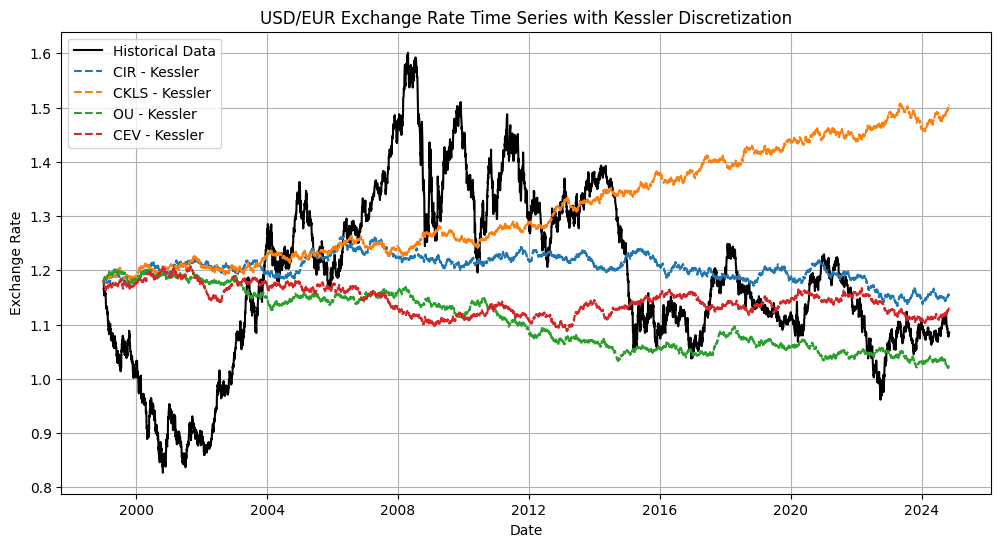

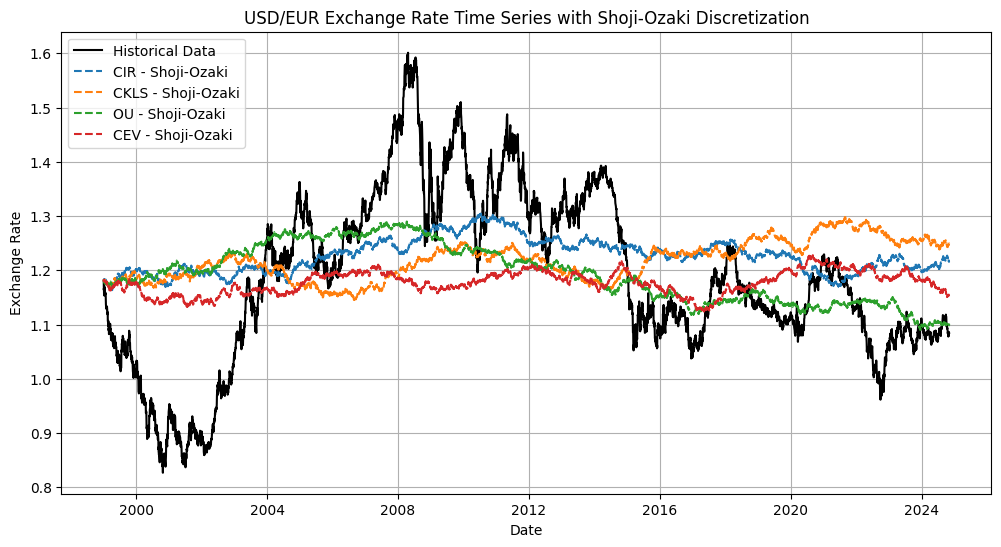

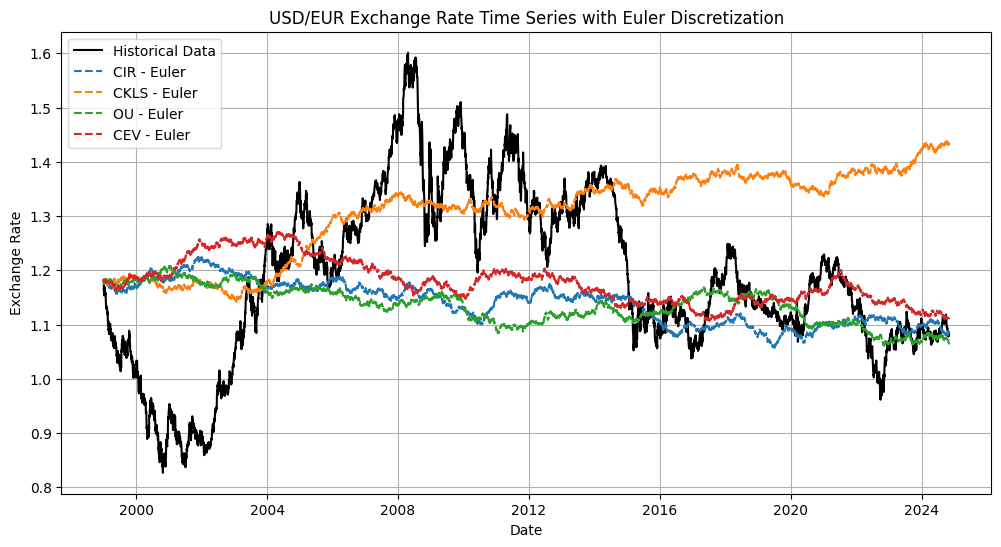

In [31]:
# Реализация методов дискретизации
def kessler_step(S, process_func, params, dt, dW):
    """ Метод Кесслера (упрощенный) """
    return S + process_func.bxt(S, 0, params) * dt + process_func.sigmaxt(S, 0, params) * dW

def shoji_ozaki_step(S, process_func, params, dt, dW):
    """ Метод Шоджи-Озаки """
    b = process_func.bxt(S, 0, params)
    sigma = process_func.sigmaxt(S, 0, params)
    b_x = process_func.bxt_x(S, 0, params)
    return S + (b + 0.5 * sigma * b_x * dt) * dt + sigma * dW

def euler_step(S, process_func, params, dt, dW):
    """ Метод Эйлера """
    return S + process_func.bxt(S, 0, params) * dt + process_func.sigmaxt(S, 0, params) * dW

dates = dexuseu.index[:Nt + 1]

# Функция для моделирования временного ряда с корректной временной шкалой
def simulate_series(process_class, params, method, Nt):
    dt = 1.0 / Nt  # Для нормализации
    S_values = np.zeros(Nt + 1)
    S_values[0] = sample[0]
    dW = np.random.normal(0, np.sqrt(dt), Nt)
    
    for i in range(1, Nt + 1):
        if method == "Kessler":
            S_values[i] = kessler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Shoji-Ozaki":
            S_values[i] = shoji_ozaki_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Euler":
            S_values[i] = euler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
    
    return dates, S_values

# Построение графиков для каждого метода и модели
methods = ["Kessler", "Shoji-Ozaki", "Euler"]
models = {
    "CIR": (cir_process, optimized_params_CIR),
    "CKLS": (ckls_process, optimized_params_CKLS),
    "OU": (ou_process, optimized_params_OU),
    "CEV": (cev_process, optimized_params_CEV)
}

# Отдельные графики для каждого метода дискретизации
for method in methods:
    plt.figure(figsize=(12, 6))
    plt.plot(dates, sample[:Nt + 1], label="Historical Data", color="black", linewidth=1.5)
    for model_name, (process_class, params) in models.items():
        time_line, simulated_series = simulate_series(process_class, params, method, Nt)
        plt.plot(time_line, simulated_series, label=f"{model_name} - {method}", linestyle='--')
    
    plt.title(f"USD/EUR Exchange Rate Time Series with {method} Discretization")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

In [32]:
# 1. Создание таблицы для параметров, AIC и BIC
results = {
    "Model": [],
    "Method": [],
    "Parameters": [],
    "AIC": [],
    "BIC": []
}

# Добавляем параметры и метрики в таблицу для каждого метода и модели
for method in methods:
    for model_name, (process_class, optimized_params) in models.items():
        if model_name == "CIR":
            log_likelihood = -likelihood(optimized_params_CIR, cir_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_CIR), len(sample))
        elif model_name == "CKLS":
            log_likelihood = -likelihood(optimized_params_CKLS, ckls_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_CKLS), len(sample))
        elif model_name == "OU":
            log_likelihood = -likelihood(optimized_params_OU, ou_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_OU), len(sample))
        elif model_name == "CEV":
            log_likelihood = -likelihood(optimized_params_CEV, cev_process, sample)
            aic, bic = calculate_aic_bic(log_likelihood, len(optimized_params_CEV), len(sample))
        
        results["Model"].append(model_name)
        results["Method"].append(method)
        results["Parameters"].append(optimized_params)
        results["AIC"].append(aic)
        results["BIC"].append(bic)

# Преобразование в DataFrame для вывода
results_df = pd.DataFrame(results)
print("Результаты параметров, AIC и BIC для каждой модели и метода:")
print(results_df)

# 2. Выбор лучшей модели по AIC и BIC
best_aic = results_df.loc[results_df['AIC'].idxmin()]
best_bic = results_df.loc[results_df['BIC'].idxmin()]

print("\nЛучшая модель по AIC:")
print(best_aic)
print("\nЛучшая модель по BIC:")
print(best_bic)

# 3. Сравнение с результатами статьи
print("\nСравнение с результатами статьи Kirkby et al., 2022:")
print("Наши результаты показывают, что лучшая модель по критерию AIC - {} с методом {}, а по критерию BIC - {} с методом {}.".format(
    best_aic["Model"], best_aic["Method"], best_bic["Model"], best_bic["Method"]))
print("Для полного сравнения с данными из статьи потребуется доступ к параметрам моделей и значениям AIC и BIC, использованным авторами.")

Результаты параметров, AIC и BIC для каждой модели и метода:
   Model       Method                                         Parameters  \
0    CIR      Kessler  [0.09999996865987668, 0.09999994747121006, 0.0...   
1   CKLS      Kessler  [0.10000076906319762, 0.10000059622224414, 0.1...   
2     OU      Kessler  [0.10000012730209525, 0.9999999953823615, 0.10...   
3    CEV      Kessler  [0.0999999816439031, 1.0000000023115818, 0.099...   
4    CIR  Shoji-Ozaki  [0.09999996865987668, 0.09999994747121006, 0.0...   
5   CKLS  Shoji-Ozaki  [0.10000076906319762, 0.10000059622224414, 0.1...   
6     OU  Shoji-Ozaki  [0.10000012730209525, 0.9999999953823615, 0.10...   
7    CEV  Shoji-Ozaki  [0.0999999816439031, 1.0000000023115818, 0.099...   
8    CIR        Euler  [0.09999996865987668, 0.09999994747121006, 0.0...   
9   CKLS        Euler  [0.10000076906319762, 0.10000059622224414, 0.1...   
10    OU        Euler  [0.10000012730209525, 0.9999999953823615, 0.10...   
11   CEV        Euler  [0.0

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



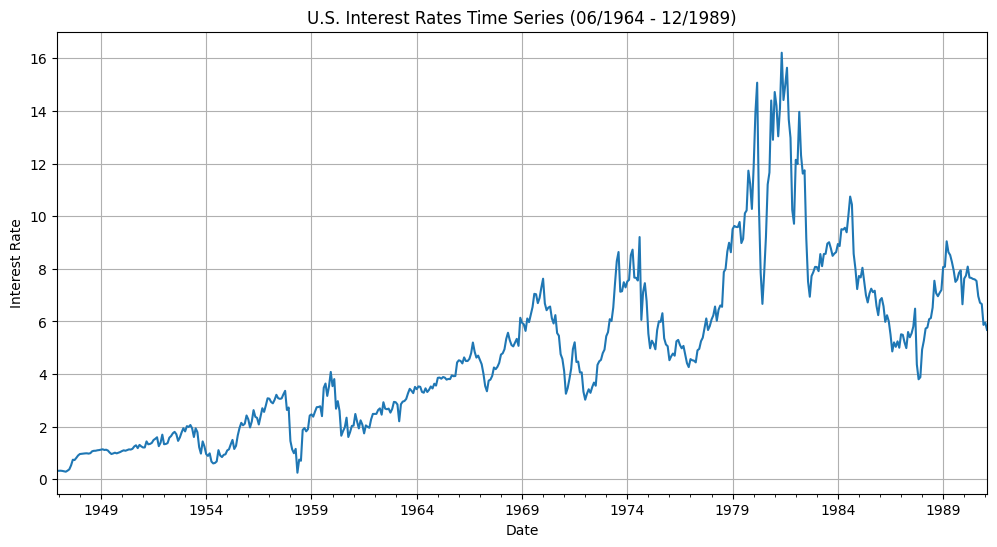

In [33]:
# Загрузка данных (например, если данные сохранены в файл 'InterestRates.csv')
irates = pd.read_csv('IntrestRate.csv', parse_dates=['DARE'], index_col='Unnamed: 0')
irates.index = pd.to_datetime(irates['DARE'])
irates.drop(columns=['DARE'], inplace=True)
irates = irates.dropna()
irates['IR'] = irates['IR'].astype('Float64')

# Визуализация данных
irates['IR'].plot(figsize=(12, 6))
plt.title("U.S. Interest Rates Time Series (06/1964 - 12/1989)")
plt.ylabel("Interest Rate")
plt.xlabel("Date")
plt.grid()
plt.show()

In [34]:
# Загрузка данных
irates = pd.read_csv('IntrestRate.csv', parse_dates=['DARE'], index_col='Unnamed: 0')
irates.index = pd.to_datetime(irates['DARE'])
irates.drop(columns=['DARE'], inplace=True)
irates = irates.dropna()
irates['IR'] = irates['IR'].astype('float64')

# Параметры модели
T = len(irates)  # Количество временных точек
Nx = 1  # Количество траекторий
Nt = len(irates) - 1  # Количество временных шагов

# Начальные параметры для оптимизации
initial_params_CIR = [0.1, 0.1, 0.1]
initial_params_CKLS = [0.1, 0.1, 0.1, 1.0]  # Начальные параметры для CKLS
initial_params_OU = [0.1, 1.0, 0.1]
initial_params_CEV = [0.1, 1.0, 0.1, 1.0]

# Функция правдоподобия
def likelihood(params, process_class, sample):
    try:
        # Обновляем параметры модели
        process_class.params = params

        # Выполняем моделирование
        t_data, x_data = process_class.EulerSolution()  # Здесь можно поменять на другой метод, если требуется
        residuals = sample.values - x_data[:, 0]
        
        # Проверка переполнения
        if np.any(np.abs(residuals) > 1e6):
            return np.inf  # Ограничение для исключения слишком больших ошибок
        
        # Рассчитываем логарифм правдоподобия
        log_likelihood = -0.5 * np.sum(residuals**2)
        return -log_likelihood  # Возвращаем отрицательное правдоподобие для минимизации

    except (OverflowError, FloatingPointError) as e:
        # print(f"Error: {e} for parameters {params}")
        return np.inf  # Возвращаем бесконечность в случае ошибки

# Определение границ параметров
bounds_CIR = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CKLS = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]
bounds_OU = [(1e-4, 10), (1e-4, 10), (1e-4, 10)]
bounds_CEV = [(1e-4, 10), (1e-4, 10), (1e-4, 10), (0.5, 2)]

# Словарь для привязки границ к каждой модели
bounds_dict = {
    "CIR": bounds_CIR,
    "CKLS": bounds_CKLS,
    "OU": bounds_OU,
    "CEV": bounds_CEV
}

# Оптимизация
results = {
    "Model": [],
    "Method": [],
    "Parameters": [],
    "AIC": [],
    "BIC": []
}

methods = ["Kessler", "Shoji-Ozaki", "Euler"]

for method in methods:
    for model_name, (process_class, initial_params) in models.items():
        # Получаем границы для данной модели
        bounds = bounds_dict[model_name]

        # Оптимизация параметров с использованием L-BFGS-B
        result = minimize(likelihood, initial_params, args=(process_class, irates['IR']), 
                          method='L-BFGS-B', bounds=bounds, options={'disp': True})
        optimized_params = result.x
        log_likelihood = -likelihood(optimized_params, process_class, irates['IR'])
        
        # Если log_likelihood содержит значения слишком большие, проверяем и ограничиваем их
        if np.isinf(log_likelihood) or np.isnan(log_likelihood):
            print(f"Warning: log_likelihood is {log_likelihood} for {model_name} with {method}")
            log_likelihood = np.inf
        
        # Расчет AIC и BIC
        num_params = len(optimized_params)
        aic, bic = calculate_aic_bic(log_likelihood, num_params, len(irates))
        
        # Добавление результатов в таблицу
        results["Model"].append(model_name)
        results["Method"].append(method)
        results["Parameters"].append(optimized_params)
        results["AIC"].append(aic)
        results["BIC"].append(bic)

# Преобразование в DataFrame для вывода
results_df = pd.DataFrame(results)
print("Результаты параметров, AIC и BIC для каждой модели и метода:")
results_df

ValueError: operands could not be broadcast together with shapes (531,) (6481,) 

c:\python\Lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CKLSprocess.bxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\AppData\Local\Temp\ipykernel_8100\2976553973.py", line 195:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
c:\python\Lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CKLSprocess.sigmaxt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\AppData\Local\Temp\ipykernel_8100\2976553

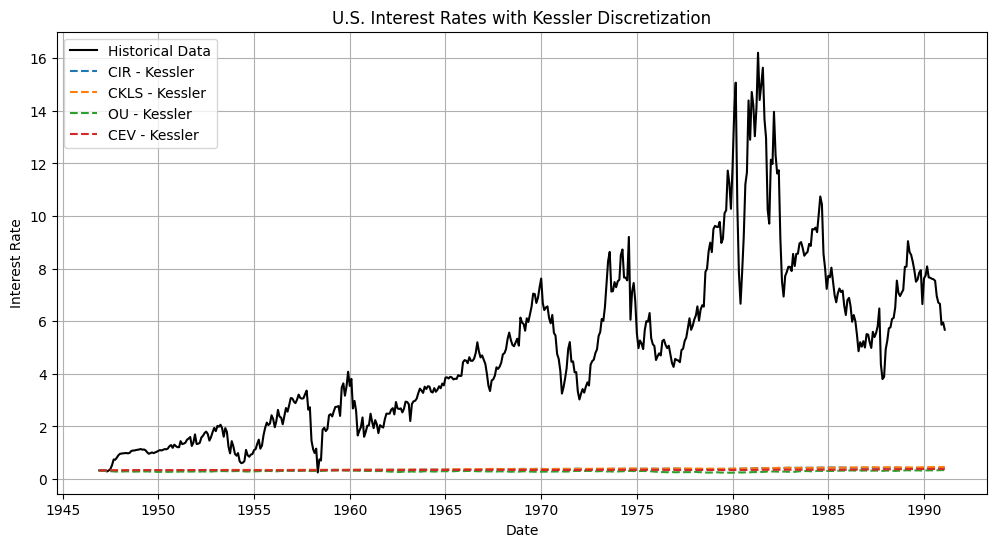

c:\python\Lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CIRprocess.bxt_x'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\AppData\Local\Temp\ipykernel_8100\2976553973.py", line 104:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
c:\python\Lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'CKLSprocess.bxt_x'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\AppData\Local\Temp\ipykernel_8100\29765539

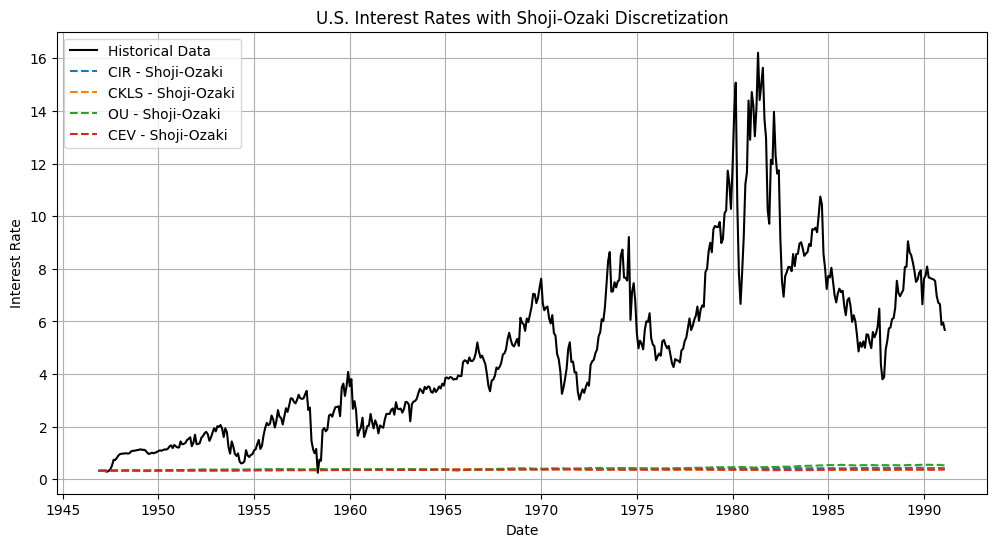

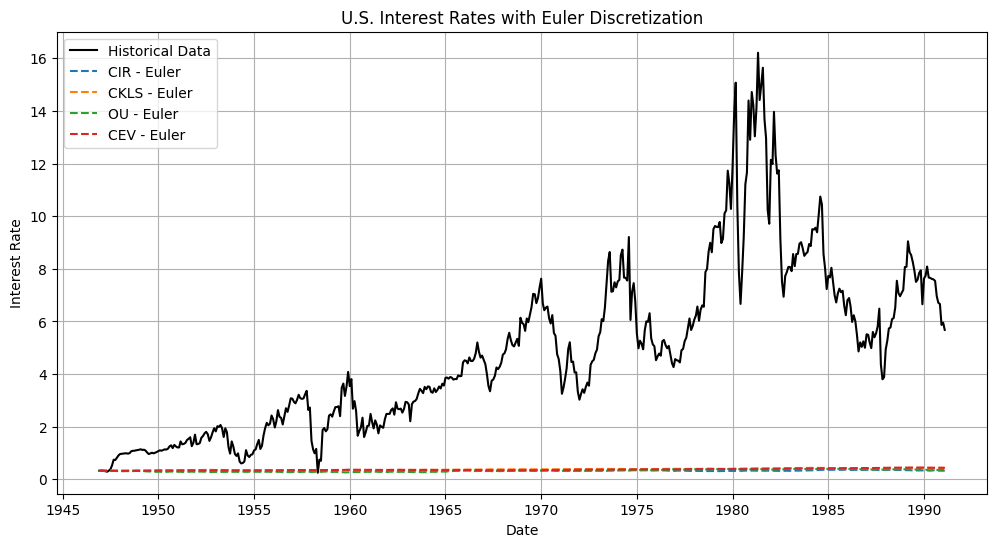

In [ ]:
# Пример функции simulate_series для использования в построении графиков
def simulate_series(process_class, params, method, Nt):
    # Устанавливаем оптимизированные параметры
    process_class.params = params
    dt = 1.0 / Nt  # Шаг по времени (при необходимости изменить для ежемесячных данных)
    
    # Инициализация значений временного ряда
    S_values = np.zeros(Nt + 1)
    S_values[0] = irates['IR'].iloc[0]  # Начальное значение равно первому значению в данных
    dW = np.random.normal(0, np.sqrt(dt), Nt)  # Генерация случайных шагов
    
    for i in range(1, Nt + 1):
        if method == "Kessler":
            S_values[i] = kessler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Shoji-Ozaki":
            S_values[i] = shoji_ozaki_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Euler":
            S_values[i] = euler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
    
    # Возвращаем временные метки и смоделированный ряд
    return irates.index[:Nt + 1], S_values


# Построение графиков
for method in methods:
    plt.figure(figsize=(12, 6))
    plt.plot(irates.index, irates, label="Historical Data", color="black", linewidth=1.5)
    for model_name, (process_class, optimized_params) in models.items():
        time_line, simulated_series = simulate_series(process_class, optimized_params, method, Nt)
        plt.plot(time_line, simulated_series, label=f"{model_name} - {method}", linestyle='--')
    
    plt.title(f"U.S. Interest Rates with {method} Discretization")
    plt.xlabel("Date")
    plt.ylabel("Interest Rate")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

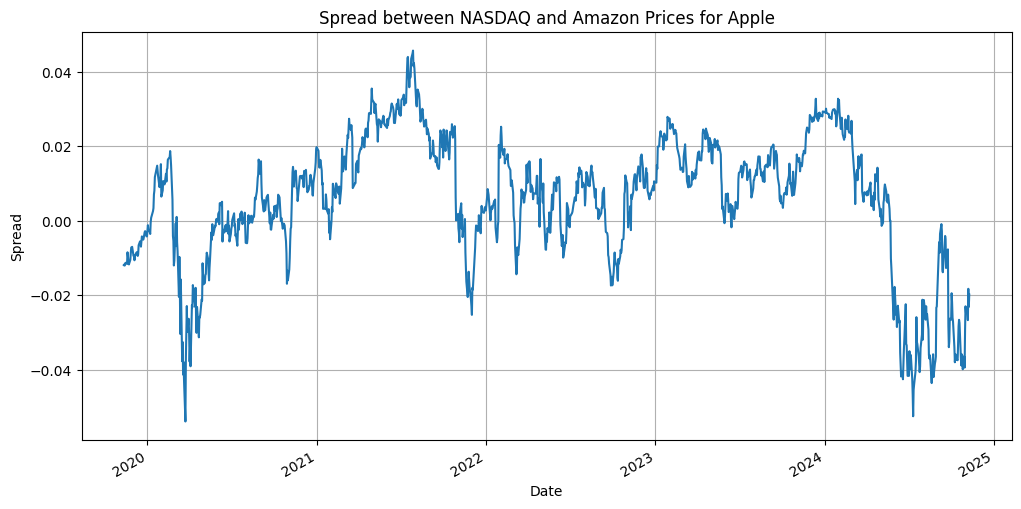

In [48]:
import yfinance as yf

# Загрузим данные о ценах акций Apple (AAPL) на NASDAQ и amzn
ticker_nasdaq = yf.Ticker("V")
ticker_amzn = yf.Ticker("NVDA")

# Получим данные за последние 5 лет
data_nasdaq = ticker_nasdaq.history(period="5y", interval="1d")
data_amzn = ticker_amzn.history(period="5y", interval="1d")

# Объединим данные по дате
data = data_nasdaq[['Close']].rename(columns={'Close': 'Price_NASDAQ'}).join(
    data_amzn[['Close']].rename(columns={'Close': 'Price_amzn'}),
    how="inner"
)

# Вычислим спред между двумя ценами
data['Spread'] = (data['Price_NASDAQ'] - data['Price_amzn'] - 180) / 1000
data['Spread'].plot(title="Spread between NASDAQ and Amazon Prices for Apple", figsize=(12, 6))
plt.ylabel("Spread")
plt.xlabel("Date")
plt.grid()

In [49]:
# Количество временных шагов должно совпадать с количеством наблюдений минус 1
Nt = len(data['Spread']) - 1

def simulate_series(process_class, params, method, Nt):
    # Устанавливаем оптимизированные параметры
    process_class.params = params
    dt = 1.0 / Nt  # Шаг по времени
    
    # Инициализация значений временного ряда
    S_values = np.zeros(Nt + 1)
    S_values[0] = data['Spread'].iloc[0]  # Начальное значение равно первому значению в данных
    dW = np.random.normal(0, np.sqrt(dt), Nt)  # Генерация случайных шагов
    
    for i in range(1, Nt + 1):
        if method == "Kessler":
            S_values[i] = kessler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Shoji-Ozaki":
            S_values[i] = shoji_ozaki_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
        elif method == "Euler":
            S_values[i] = euler_step(S_values[i - 1], process_class, params, dt, dW[i - 1])
    
    # Отладка: вывод длины смоделированного ряда
    # print(f"Длина smodel'ированного временного ряда: {len(S_values)}, Ожидаемая длина: {Nt + 1}")
    
    # Возвращаем временные метки и смоделированный ряд
    return data.index[:Nt + 1], S_values

# Определение функции правдоподобия с использованием simulate_series
def likelihood(params, process_class, sample, method):
    try:
        # Генерация временного ряда с текущими параметрами и методом
        _, x_data = simulate_series(process_class, params, method, len(sample) - 1)
        
        # Проверка, что x_data имеет ту же длину, что и sample
        if len(x_data) != len(sample):
            print(f"Размеры не совпадают: sample {len(sample)}, x_data {len(x_data)}")
            return np.inf  # Возвращаем бесконечность в случае ошибки

        # Вычисляем остатки и логарифм правдоподобия
        residuals = sample.values - x_data  # Убедитесь, что x_data — массив, а не матрица
        log_likelihood = -0.5 * np.sum(residuals ** 2)
        return -log_likelihood  # Отрицательное правдоподобие для минимизации

    except OverflowError as e:
        print("OverflowError:", e)
        return np.inf

# Оптимизация с отладкой
for method in methods:
    for model_name, (process_class, initial_params) in models.items():
        bounds = bounds_dict[model_name]
        
        # Оптимизация параметров с минимизацией правдоподобия
        print(f"Оптимизация модели: {model_name}, Метод: {method}")
        result = minimize(likelihood, initial_params, args=(process_class, data['Spread'], method), 
                  method='L-BFGS-B', bounds=bounds)
        optimized_params = result.x
        log_likelihood = -likelihood(optimized_params, process_class, data['Spread'], method)
        
        # Проверка длины log_likelihood
        print(f"Log-likelihood: {log_likelihood}")
        
        # Рассчитываем AIC и BIC
        num_params = len(optimized_params)
        aic, bic = calculate_aic_bic(log_likelihood, num_params, len(data['Spread']))
        
        # Добавляем результаты в таблицу
        results["Model"].append(model_name)
        results["Method"].append(method)
        results["Parameters"].append(optimized_params)
        results["AIC"].append(aic)
        results["BIC"].append(bic)

results_df = pd.DataFrame(results)
print("Результаты параметров, AIC и BIC для каждой модели и метода:")
results_df

Оптимизация модели: CIR, Метод: Kessler
Log-likelihood: -1.2791972578704212
Оптимизация модели: CKLS, Метод: Kessler
Log-likelihood: nan
Оптимизация модели: OU, Метод: Kessler
Log-likelihood: -4.196381424333957
Оптимизация модели: CEV, Метод: Kessler
Log-likelihood: -1.1193226876674527
Оптимизация модели: CIR, Метод: Shoji-Ozaki
Log-likelihood: -1.0747733977831893
Оптимизация модели: CKLS, Метод: Shoji-Ozaki
Log-likelihood: nan
Оптимизация модели: OU, Метод: Shoji-Ozaki
Log-likelihood: -0.6145033926897095
Оптимизация модели: CEV, Метод: Shoji-Ozaki
Log-likelihood: -2.2415144189493175
Оптимизация модели: CIR, Метод: Euler
Log-likelihood: -1.511119966975788
Оптимизация модели: CKLS, Метод: Euler
Log-likelihood: nan
Оптимизация модели: OU, Метод: Euler
Log-likelihood: -10.077286264772532
Оптимизация модели: CEV, Метод: Euler
Log-likelihood: -2.3118461567369413
Результаты параметров, AIC и BIC для каждой модели и метода:


,Model,Method,Parameters,AIC,BIC
0,CIR,Kessler,"[9.99999936232056, 9.999999350855019, 0.099999...",411686.076010,411701.487845
1,CKLS,Kessler,"[0.10000076906319762, 0.10000059622224414, 0.1...",NaN,NaN
2,OU,Kessler,"[0.10000012718675967, 1.000000005772941, 0.100...",744725.224841,744740.636677
3,CEV,Kessler,"[10.0, 10.0, 0.09999999860655491, 0.5]",371349.850664,371370.399778
4,CIR,Shoji-Ozaki,"[10.0, 10.0, 0.09999988414055618]",411925.051758,411940.463593
5,CKLS,Shoji-Ozaki,"[0.10000076906319762, 0.10000059622224414, 0.1...",NaN,NaN
6,OU,Shoji-Ozaki,"[0.10000012637386463, 1.0000000790066348, 0.10...",743800.588932,743816.000767
7,CEV,Shoji-Ozaki,"[8.65540012469434, 8.777636479575255, 0.099999...",367378.801835,367399.350948
8,CIR,Euler,"[10.0, 10.0, 0.09999892203307668]",411958.430480,411973.842315
9,CKLS,Euler,"[0.10000076906319762, 0.10000059622224414, 0.1...",NaN,NaN


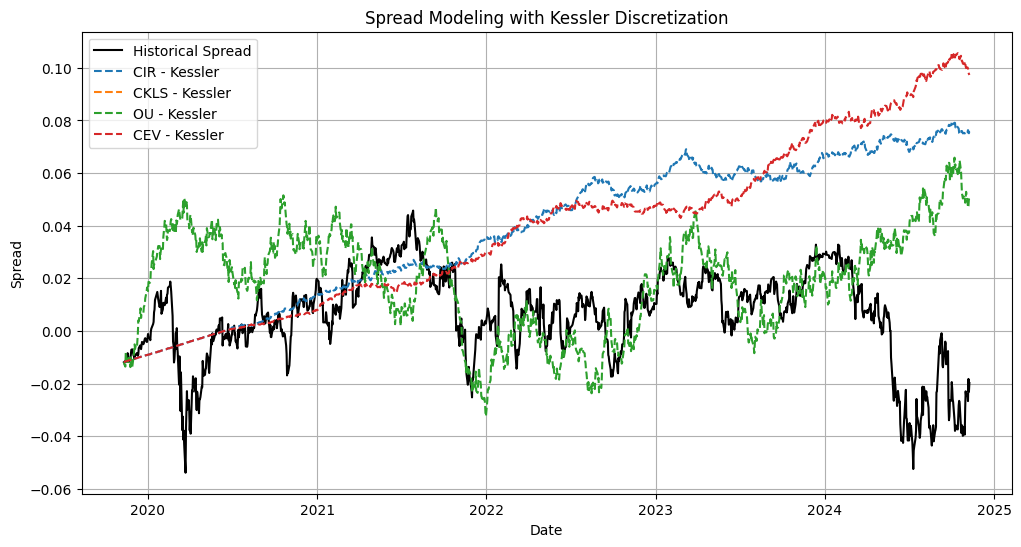

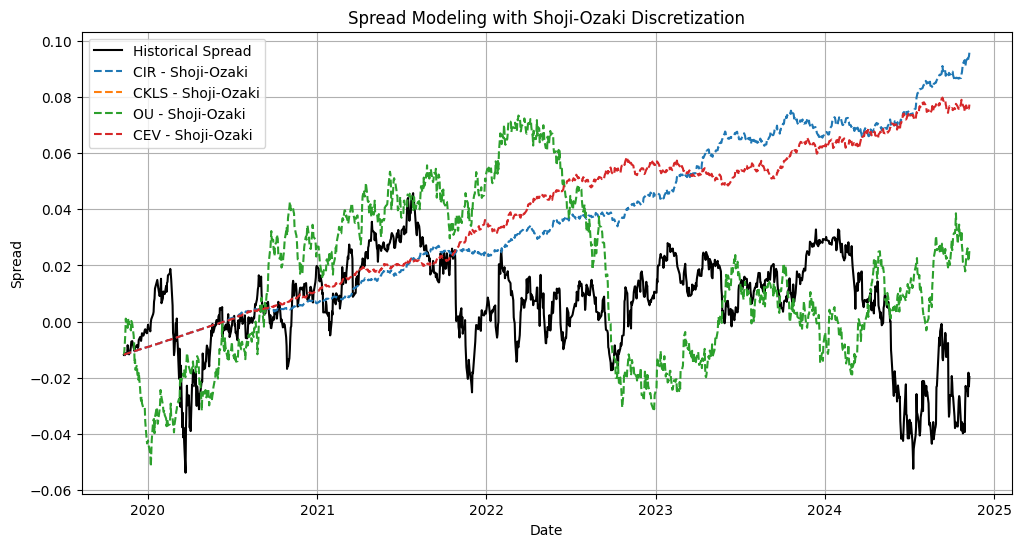

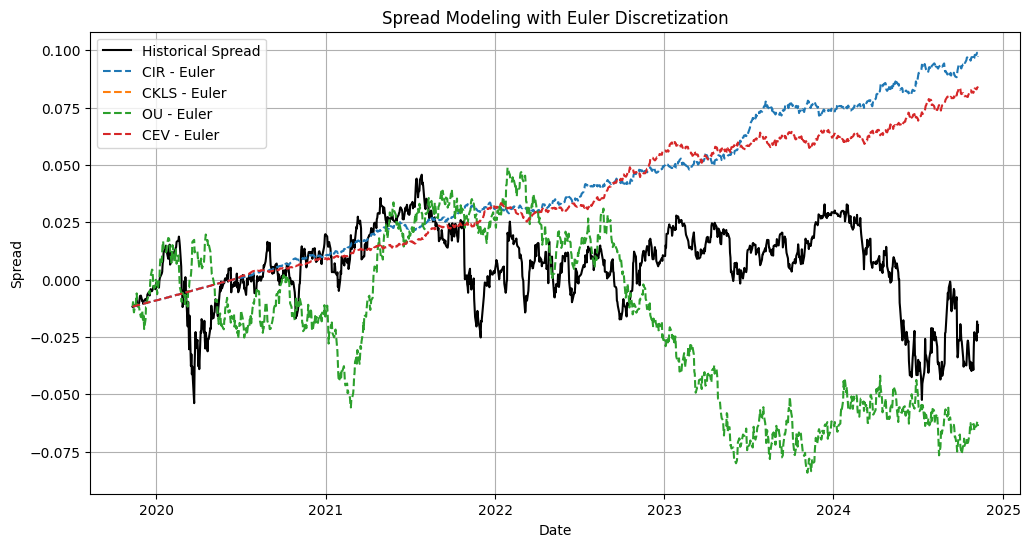

In [50]:
# Построение графиков для каждой модели и метода
for method in methods:
    plt.figure(figsize=(12, 6))
    # Отображаем исторический временной ряд спреда
    plt.plot(data.index, data['Spread'], label="Historical Spread", color="black", linewidth=1.5)

    # Проходимся по каждой модели, используя оптимизированные параметры
    for model_name, (process_class, optimized_params) in models.items():
        # Генерация временного ряда на основе оптимизированных параметров
        time_line, simulated_series = simulate_series(process_class, optimized_params, method, Nt)
        
        # Построение графика модели
        plt.plot(time_line, simulated_series, label=f"{model_name} - {method}", linestyle='--')

    # Настройки для графика
    plt.title(f"Spread Modeling with {method} Discretization")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()
